# Toxic Comment Classification

With the increase of cyberbullying, in both frequency and intensity, it is important to identify ways to protect these victims. The goal of this project is to use technology and machine learning to identify and classify toxic online comments, with the hope of remediating them and making online experiences safer and more wholesome.


### Package Installation
I am installing all the necessary packages needed to create my solution below. Key technologies include Pandas, NTLK, SKlearn, Keras and Tensorflow backend.

In [1]:
import sys
import os 
import re
import csv 
import nltk
import codecs
import boto3
import json
import string
from methods import *

from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import initializers, regularizers, constraints, optimizers, layers

%matplotlib inline

Using TensorFlow backend.


---

## Data Loading
Below I am loading the two core data files from the data directory: training data set and testing data set. Each comment is labeled using the following classes:

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate


In [156]:
train = pd.read_csv(os.path.join(os.getcwd(), 'data/train.csv'))
test = pd.read_csv(os.path.join(os.getcwd(), 'data/test.csv'))
test_labels = pd.read_csv(os.path.join(os.getcwd(), 'data/test_labels.csv'))

---

## Data Exploration
Below are some examples of raw comments including a general/positive comment, a comment labeled as insult, a comment labeled identity hate, and a comment generally marked as toxic.

#### General/Positive

In [3]:
train[(train.toxic==0) & (train.severe_toxic==0) & (train.threat==0) & 
      (train.insult==0) & (train.identity_hate==0) & (train.obscene==0)]['comment_text'].any()

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

#### Toxic

In [4]:
train[train['toxic'] == 1]['comment_text'].any()

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

#### Identity Hate

In [5]:
train[(train.toxic==0) & (train.severe_toxic==0) & (train.threat==0) & 
      (train.insult==0) & (train.identity_hate==1) & (train.obscene==0)]['comment_text'].any()

'Mate, sound like you are jewish\n\nGayness is in the air'

#### Insult

In [6]:
train[(train.toxic==0) & (train.severe_toxic==0) & (train.threat==0) & 
      (train.insult==1) & (train.identity_hate==0) & (train.obscene==0)]['comment_text'].any()

"REPLY ABOVE:\nThat was me, loser. The UN defines Vietnam to be part of Southeast Asia. And far as I know Vietnam is part of ASEAN, and used to be part of French Indochina with Laos and all those shit countries Anyway your culture has always been more influenced by SEA than Han Chinese (as in proper Yangtze Han Chinese, not the fringe indigenous tribes in Guangzhou/Guangxi). \n\nJust admit that you vietnamese are all a bunch of wannabe crap people. ALL the east asian people I've spoken to thinks of Vietnam as a very integral part of SEA, and we all think you're backward, dirty and speak in a horrible swearing language. Doesn't matter what crap you spout on Wikipedia, won't change the way people in the real world think."

### ngrams
An n-gram is a set of n items or words extracted from a sentence or larger copurs of text. In this case I am using it as a method to explore the data and understand the concentration of phrases and sentiment across the dataset.

Below are a few examples of ngrams from the given data set using, where n=2

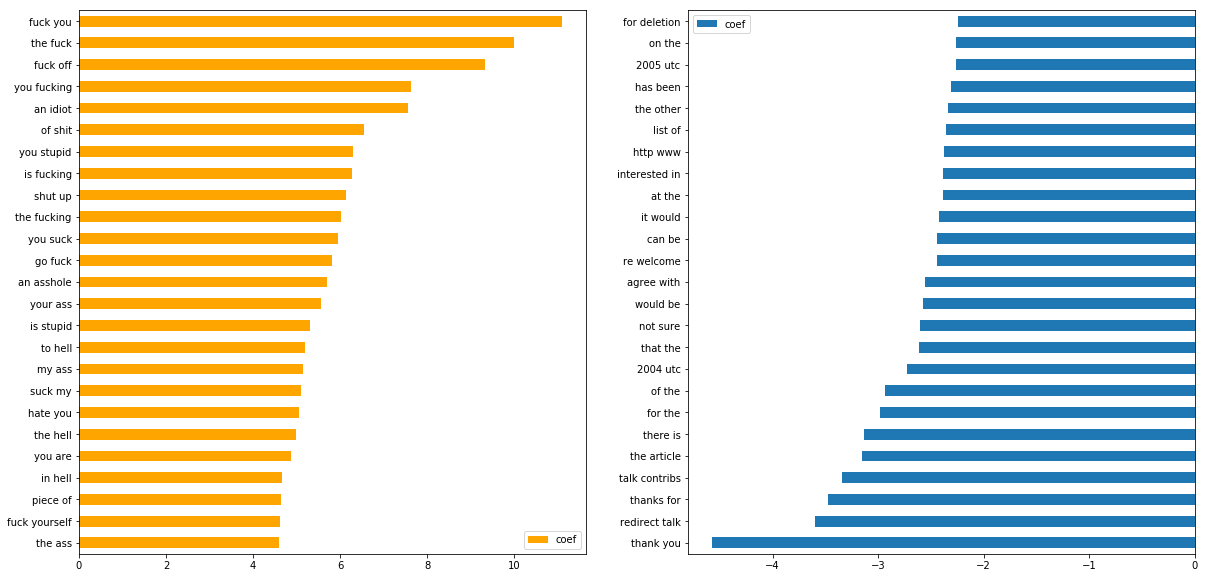

In [7]:
plot_polarity(train, ngram_range=(2, 2))

Below are a few examples of ngrams from the given data set using, where n=3

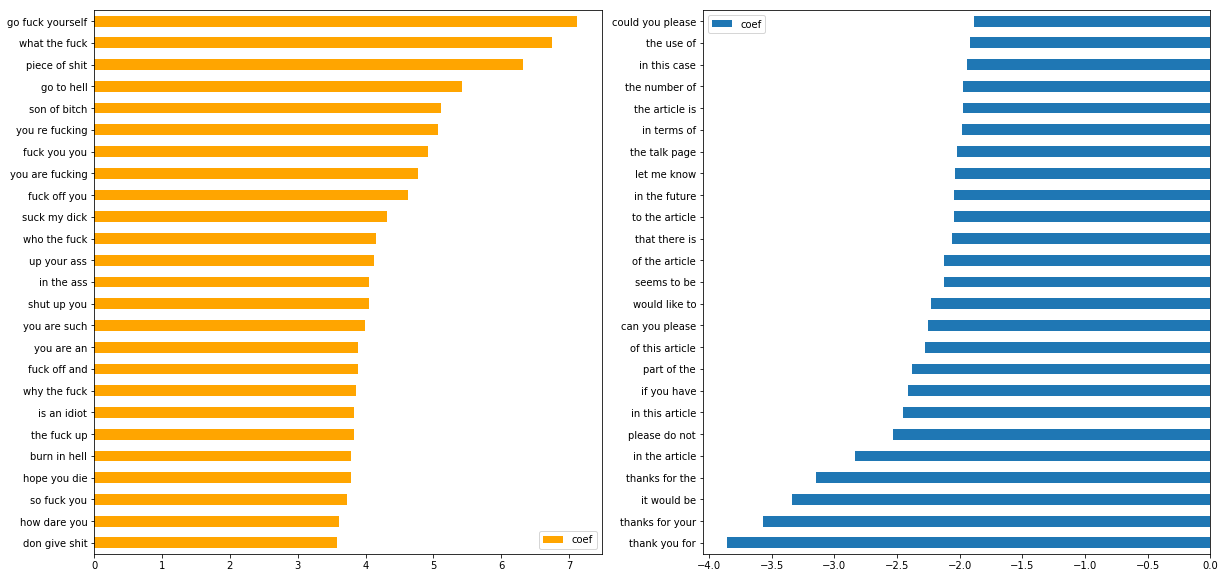

In [8]:
plot_polarity(train, ngram_range=(3, 3))

### class distribution
The chart below identifies the distribution of the data across the various classes.

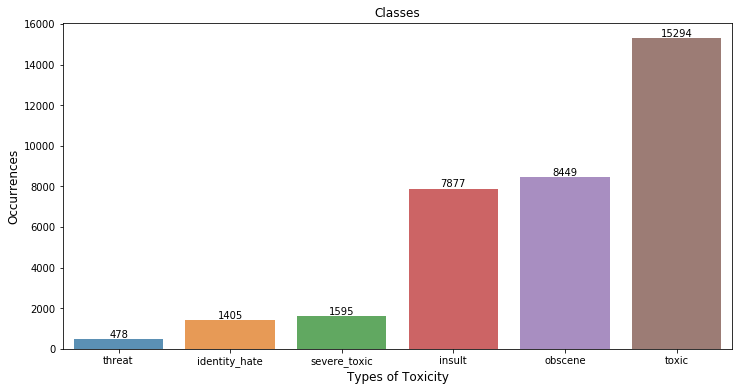

In [9]:
plot_class_distribution(train, title='Classes', xlabel='Types of Toxicity', ylabel='Occurrences')

We can see that comments are labeled as toxic in an overwhelming number of cases. Following, toxic, obscene and insult are the next most frequent, leaving severe toxic, identity hate and threat as the least represented classes.

---

## Data Preparation
Ensure that NLTK data (punkt, wordnet, stopwords) is installed and up to date.

In [10]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Next we prep the data using NLTK and a function from methods.py called <b>clean_text</b>. This method transforms all text to lowercase, removes all symbols and line breaks, lemmatizes all words in each sentence and removes all English stop words.

In [11]:
% time
train['comment_text'] = train['comment_text'].apply(clean_text)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


Once the training data is cleaned we prep the use in the model by seperating the comments and the labels.

In [38]:
train_sentences = train["comment_text"].values
test_sentences = test["comment_text"].values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
labels = train[list_classes].values

The prepped data is then tokenized.

In [15]:
num_words = 20000
maxlen = 100

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(train_sentences))                
                       
train_tokenized = tokenizer.texts_to_sequences(train_sentences)
X_train = pad_sequences(train_tokenized, maxlen=maxlen)                     
                       
test_tokenized = tokenizer.texts_to_sequences(test_sentences)
X_test = pad_sequences(test_tokenized, maxlen=maxlen)       

I've also read in a file of Global Vectors for Word Representation (GloVe) to create our embeddings.

In [23]:
glove_path = os.path.join(os.getcwd(), 'input/glove.6B.50d.txt')
embedding_index = dict(parse_glove_file(*o.strip().split()) for o in open(glove_path))
embeddings = np.stack(embedding_index.values())
embed_mean, embed_std = embeddings.mean(), embeddings.std()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  app.launch_new_instance()


Finally the tokenized data set is combined with the GloVe embeddings to create our embeddings matrix. In this step there is also a  random initialization for any words that aren't in GloVe. For consistency I've applied the existing mean and standard deviation.

In [24]:
word_index = tokenizer.word_index
nb_words = min(num_words, len(word_index))
embed_size = 50
embedding_matrix = np.random.normal(embed_mean, embed_std, (nb_words, embed_size))

for word, i in word_index.items():
    
    if i >= num_words: 
        continue
        
    embedding_vector = embedding_index.get(word)
    
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

---

## model

I’ve opted to utilize a LTSM neural network for this project. Long Short Term Memory networks are a specific type of Recurrent Neural Network that are able to maintain information for longer periods of time. This ability to “remember” makes them ideal for solving natural language processing tasks and problems.

My specific model uses the Keras Bidirectional LTSM function. The model also uses two activation functions: a ReLu as well as a Sigmoid. The Sigmoid is the final activation function, which is important for normalizing the results across the various labels among which the data can be classified.

One additional note is that I’ve included dropout throughout the model. Dropout is when a random portion of the data is omitted from certain passes through the model. This provides some flexibility in the way the model handles the data and is largely used as an effort to prevent overfitting. 

In [145]:
import tensorflow as tf

maxlen = 100
inputs = Input(shape=(maxlen,))
outputs = model_outputs(num_words, embed_size, embedding_matrix, inputs)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Once the model is created an instanstiated we fit it using the training data set. I am allowing for two epochs of training in this case. While one epoch yielded results that were less than satisfactory, more than two would cause concern for overfitting, even in light of the utilization of dropout mentioned above. 

In [26]:
model.fit(X_train, labels, batch_size=32, epochs=2, validation_split=0.1);



Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 2275s 16ms/step - loss: 0.0610 - acc: 0.9789 - val_loss: 0.0505 - val_acc: 0.9812
Epoch 2/2
143613/143613 [==============================] - 2281s 16ms/step - loss: 0.0457 - acc: 0.9825 - val_loss: 0.0470 - val_acc: 0.9821


In [138]:
# y_pred = model.predict([X_test], batch_size=1024, verbose=1)
y_pred = model.predict(X_test, verbose=1)

153164/153164 [==============================] - 203s 1ms/step


In [150]:
sample = pd.read_csv(os.path.join(os.getcwd(), 'data/sample_submission.csv'))
sample[list_classes] = y_pred
sample.to_csv(os.path.join(os.getcwd(), 'submission.csv'), index=False)

--- 

## validation
Let's look at a sampling of the data to see if the predictions are accurate.

In [153]:
test_sentences[0]

"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"

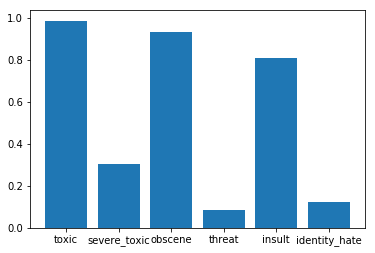

In [155]:
plt.bar(list_classes, y_pred[0])
plt.show()